In [1]:
# Imports
import numpy as np
import pandas as pd
#import hvplot.pandas

%matplotlib inline


Bad key text.latex.preview in file C:\Users\UNIVE\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\UNIVE\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\UNIVE\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, 

In [2]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [4]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [5]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [6]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [7]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 7

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)
#print (f"X sample values:\n{X[:5]} \n")
#print (f"y sample values:\n{y[:5]}")

In [8]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler to scale data between 0 and 1.
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [13]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [14]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 5)              140       
                                                                 
 dropout (Dropout)           (None, 7, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 5)              220       
                                                                 
 dropout_1 (Dropout)         (None, 7, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [15]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
374/374 [==============================] - 23s 17ms/step - loss: 0.0883
Epoch 2/10
374/374 [==============================] - 8s 21ms/step - loss: 0.0460
Epoch 3/10
374/374 [==============================] - 8s 21ms/step - loss: 0.0379
Epoch 4/10
374/374 [==============================] - 7s 19ms/step - loss: 0.0297
Epoch 5/10
374/374 [==============================] - 9s 24ms/step - loss: 0.0233
Epoch 6/10
374/374 [==============================] - 8s 22ms/step - loss: 0.0180
Epoch 7/10
374/374 [==============================] - 9s 25ms/step - loss: 0.0172
Epoch 8/10
374/374 [==============================] - 10s 28ms/step - loss: 0.0156
Epoch 9/10
374/374 [==============================] - 9s 23ms/step - loss: 0.0151
Epoch 10/10
374/374 [==============================] - 7s 18ms/step - loss: 0.0152


In [17]:
# Evaluate the model
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 9ms/step - loss: 0.0460


0.046021729707717896

In [18]:
# Make some predictions
predicted = model.predict(X_test)

In [19]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-19,3912.570068,3761.744385
2019-02-20,3924.239990,3765.872314
2019-02-21,3974.050049,3777.987061
2019-02-22,3937.040039,3800.387939
2019-02-23,3983.530029,3830.162354


<AxesSubplot:title={'center':'Closing Prices'}>

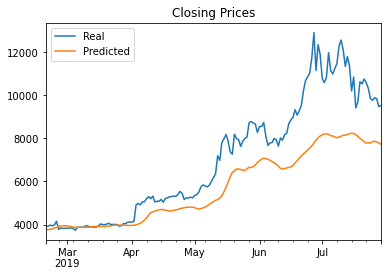

In [21]:
# Plot the real vs predicted values as a line chart
stocks.plot(title='Closing Prices')